In [3]:
import os
import torch
from tqdm import tqdm
# change working directory 
os.chdir( os.path.join( os.environ["VSC_DATA"], "physioex" ) )

from physioex.train.utils.fast_train import FastEvalDataset
from physioex.train.models import load_model
from torch.utils.data import DataLoader

dataset = "sleepedf"
device = "cuda" if torch.cuda.is_available() else "cpu"

model_kwargs = {
    "in_channels": 3,
    "sequence_length": 21,
    "N" : 1,
    "S" : 2,
    "n_prototypes" : 50,
}

def load_dataset( dataset ):
    eval_dataset = FastEvalDataset(
        datasets = [dataset],
        preprocess = "xsleepnet",
        indexed_channels = [0, 1, 2],
        split = "test",
        data_folder=f"/readonly/{os.environ['VSC_SCRATCH_PROJECTS_BASE']}/2024_111/guido/"
    )

    eval_loader = DataLoader(
        eval_dataset,
        batch_size=1,
        num_workers=1,
    )

    return eval_loader


def load_finetuned_model( dataset ):
    proto = load_model(
        model = "physioex.train.networks.prototypev1:ProtoSleepNetV1",
        model_kwargs = model_kwargs,
        ckpt_path = f"models/fast/protosleepnetv1/{dataset}/EEG-EOG-EMG/model.ckpt",
        softmax = True,
        summary = False,
    ).eval()

    return proto

model = load_finetuned_model( dataset )
eval_loader = load_dataset( dataset )

2025-06-10 10:25:37.882 | INFO     | physioex.train.utils.fast_train:__init__:70 - Loading FastEvalDataset for sleepedf with preprocess xsleepnet


Input shape: torch.Size([2030, 3, 29, 129])
Target shape: torch.Size([2030])


100%|██████████| 2010/2010 [00:37<00:00, 54.06it/s]

Coverage mean: 7.084592819213867, std: 0.5849195122718811
Coverage min: 5.095237731933594, max: 8.968255043029785
Accuracy: 83.35%


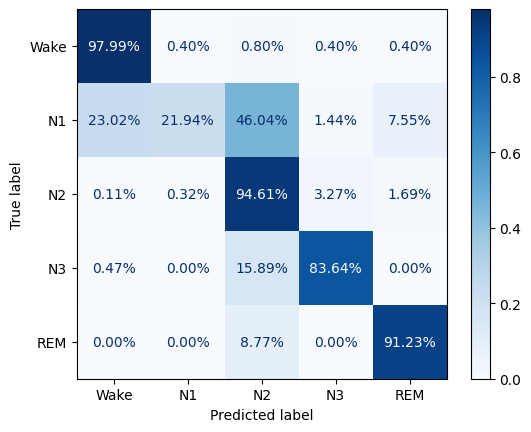

In [9]:
# load the first evaluation subject
for batch in eval_loader:
    x, y, _, _ = batch
    
    x = x.squeeze(0)  # remove batch dimension
    y = y.squeeze(0)  # remove batch dimension
    
    print(f"Input shape: {x.shape}")
    print(f"Target shape: {y.shape}")
    break

night_length = x.shape[0]  
L = model_kwargs["sequence_length"]

night_proba = torch.zeros( night_length, 5 )
night_prototypes = torch.zeros( night_length, model_kwargs["n_prototypes"] )

coverage = []

model = model.to(device)
for i in tqdm(range( night_length - L + 1 )):
    x_batch = x[i:i+L].unsqueeze(0)  # add batch dimension
    y_batch = y[i:i+L]
    
    # forward pass
    with torch.no_grad():
        preds = model(x_batch.to(device)).squeeze(0).detach().cpu()

        _, _, indexes, _, _ = model[0].nn.get_prototypes(x_batch.to(device))
        _, _, (alphas, mask) = model[0].nn.encode(x_batch.to(device), return_alphas=True)
        
        mask = mask.squeeze(0).detach().cpu() 
        T = mask.shape[-1]
        mask = (mask.sum( dim = -1 ) / ((T//2)+1)).reshape( -1 ).mean().item()  
        coverage.append(mask)
        
        alphas = alphas.reshape( -1, 1, model_kwargs["in_channels"] ).detach()
        indexes = indexes.reshape( -1, model_kwargs["in_channels"], 1 ).detach()
        indexes = torch.einsum( "bnc, bcn -> bn", alphas.float(), indexes.float() ).long().cpu()

        for j in range( len(indexes) - 1 ):
            night_prototypes[i + j, indexes[j]] += 1 
             
    night_proba[i:i+L] += preds  # store the predictions

model = model.cpu()  # move model back to CPU if needed
coverage = torch.tensor(coverage) * ((T//2)+1)
print(f"Coverage mean: {coverage.mean().item()}, std: {coverage.std().item()}")
print( f"Coverage min: {coverage.min().item()}, max: {coverage.max().item()}" )

# get the probabilities for the whole night
night_proba = night_proba / night_proba.sum(dim=1, keepdim=True)

# get the prototypes for the whole night
night_prototypes = torch.argmax(night_prototypes, dim=1)

# normalize the prototype transitions

# print the accuracy
print(f"Accuracy: { (night_proba.argmax(dim=1) == y).float().mean().item() * 100:.2f}%")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [0, 1, 2, 3, 4]
display_labels = ["Wake", "N1", "N2", "N3", "REM"]

cm = confusion_matrix(y, night_proba.argmax(dim=1), labels=labels, normalize="true")  # normalizza per riga

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap="Blues", values_format=".2%")  # mostra una cifra decimale


100%|██████████| 2029/2029 [00:00<00:00, 30326.57it/s]


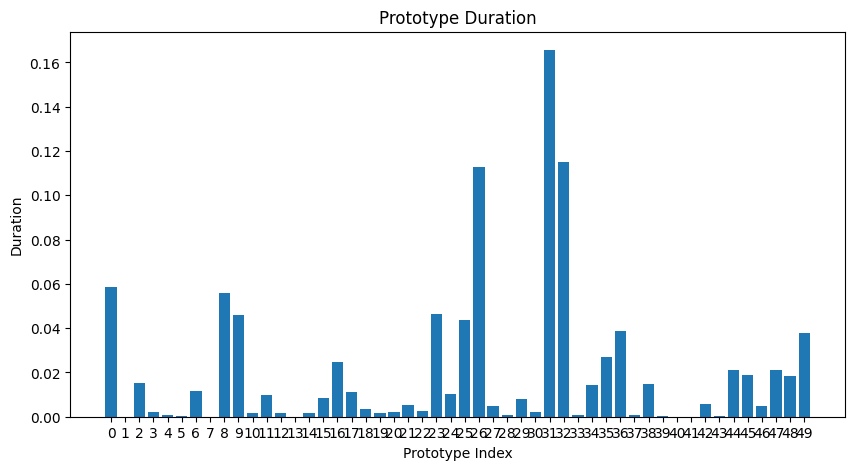

In [3]:
# descriptor of how the prototypes transition from one to another
transition_matrix = torch.zeros( model_kwargs["n_prototypes"], model_kwargs["n_prototypes"] )
prototype_class = torch.zeros( model_kwargs["n_prototypes"], 5 )
prototype_duration = torch.zeros( model_kwargs["n_prototypes"] )

for i in tqdm( range( night_length - 1 ) ):
    transition_matrix[ night_prototypes[i], night_prototypes[i+1] ] += 1
    prototype_duration[ night_prototypes[i] ] += 1
    prototype_class[ night_prototypes[i] ] += night_proba[i]

# we want the prototype duration in percentage of the whole night
prototype_duration = prototype_duration / prototype_duration.sum() 

# we want the prototype class as a probability distribution
#prototype_class = prototype_class / prototype_class.sum(dim=1, keepdim=True)

# plot the prototype duration in a bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(range(model_kwargs["n_prototypes"]), prototype_duration.numpy())
plt.xlabel("Prototype Index")
plt.ylabel("Duration")
plt.title("Prototype Duration")
plt.xticks(range(model_kwargs["n_prototypes"]))
plt.show()


In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

print( prototype_class[:10].sum(dim=1) )

tensor([119.0000,   0.0000,  31.0000,   4.0000,   2.0000,   1.0000,  24.0000,
          0.0000, 113.0000,  93.0000])


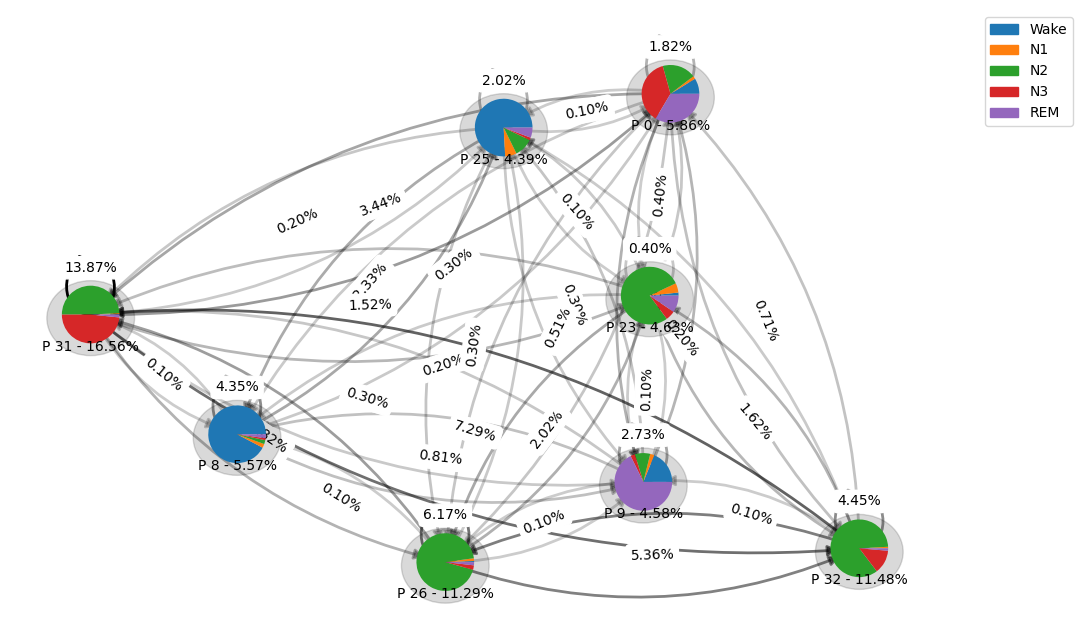

Total duration of the night represented by the graph: 72.06%
Number of prototypes: 10


In [24]:
figsize = (12, 8)
duration_threshold = 0.03
transition_treshold = 0

T = transition_matrix.numpy()
D = prototype_duration.numpy()
C = prototype_class.numpy()

# we want to filter out the prototypes that have a duration below the threshold
valid_prototypes = np.where(D > duration_threshold)[0]

# filter the elements of the transition matrix by setting row and column to zero if the prototype is not valid
T[:, ~np.isin(np.arange(T.shape[1]), valid_prototypes)] = 0
T[~np.isin(np.arange(T.shape[0]), valid_prototypes), :] = 0

# now we want to normalize the transition matrix by the total number of transitions for the whole night
P = T / T.sum(axis=1).sum(axis=0)


state_distributions = {i: C[i] for i in range(P.shape[0])}


G = nx.DiGraph()
for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        if P[i][j] > transition_treshold:  # only add edges with non-zero probability and avoid self-loops
            G.add_edge(i, j, weight=P[i][j])

pos = nx.kamada_kawai_layout(G) # 'dot' per layout gerarchico


fig, ax = plt.subplots(figsize=figsize)

# Disegna archi con alpha proporzionale al peso
edges = G.edges(data=True)
weights = np.array([attr['weight'] for _, _, attr in edges])
if len(weights) > 0:
    min_w, max_w = weights.min(), weights.max()
else:
    min_w, max_w = 0, 1

for (u, v, attr) in edges:
    alpha = 0.2 + 0.8 * (attr['weight'] - min_w) / (max_w - min_w + 1e-8)
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)], ax=ax,
        arrows=True,
        arrowstyle='-|>',           # freccia marcata
        arrowsize=15,               # dimensione freccia
        connectionstyle='arc3,rad=0.2',
        alpha=alpha,
        width=2,
        min_source_margin=15,       # margine per evitare sovrapposizione con i pie chart
        min_target_margin=15
    )

nx.draw_networkx_edge_labels(
    G, pos, edge_labels={(i, j): f"{P[i][j]:.2%}" for i, j in G.edges()}, ax=ax
)

pie_size = 0.2

# Pie chart con ombra
for node in G.nodes():
    x, y = pos[node]
    # Ombra (cerchio grigio sotto)
    shadow = plt.Circle((x, y - pie_size*0.05), pie_size*0.52, color='k', alpha=0.15, zorder=1, transform=ax.transData)
    ax.add_patch(shadow)
    # Pie chart
    pie_ax = ax.inset_axes([x - pie_size/2, y - pie_size/2, pie_size, pie_size], transform=ax.transData, zorder=2)
    
    dist = state_distributions[node]
    
    if dist.sum() == 0 or np.isnan(dist).any():
        print(f"Warning: Node {node} has an invalid distribution: {dist}")
    
    colors = plt.cm.tab10.colors[:len(dist)]
    pie_ax.pie(dist, colors=colors)
    pie_ax.set_aspect('equal')
    pie_ax.axis('off')

# Etichette dei nodi Prototype - {P_id} - Duration: {D[P_id]:.2%}
for node in G.nodes():
    x, y = pos[node]
    ax.text(x, y - 0.1, f"P {node} - {D[node]:.2%}", ha='center')

# Legenda per i colori dei pie chart
labels = ["Wake", "N1", "N2", "N3", "REM"]
colors = plt.cm.tab10.colors[:len(labels)]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
ax.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.15, 1))

ax.axis('off')
plt.show()

# print the total duration of the night represented by the graph
total_duration = prototype_duration[valid_prototypes].sum()
print(f"Total duration of the night represented by the graph: {total_duration:.2%}")
print(f"Number of prototypes: {len(valid_prototypes)}")
